# 시계열 예측 비교
- 랜덤 포레스트
- 선형 모델
- MLP
- CNN
- RNN

## 예측 타입
- 단변수 예측
- 멀티스텝 예측
- 다중변수 예측
- 다중변수 멀티스텝 예측


In [23]:
!pip install tensorflow

In [24]:
 !pip install keras

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import r2_score
#from keras.layers import Dense
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU, LSTM, SimpleRNN
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
import tensorflow 
import keras

# 데이터 다운로드

In [42]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 자전거 대여수 (시계열 데이터)

In [43]:
count = df["count"].values
print(count.shape)

(10886,)


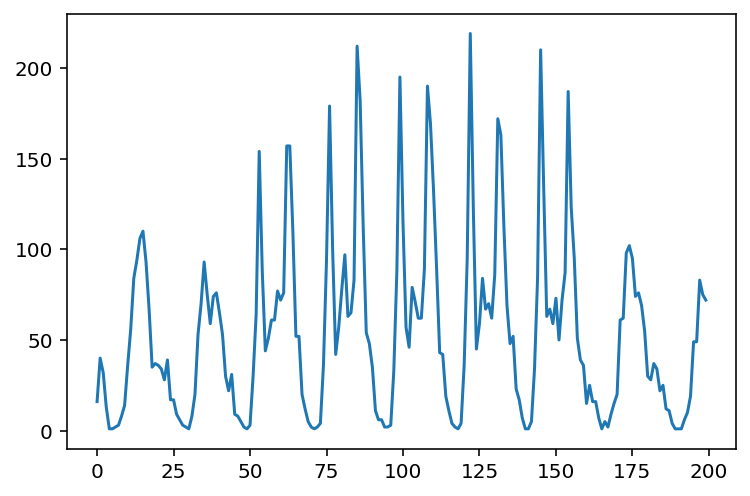

In [44]:
plt.plot(count[:200])

# 머신러닝 방법
- 랜덤 포레스트

## datetime 날짜 데이터 분해

In [45]:
df['datetime'].dt.year

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [46]:
df["d-year"] = df["datetime"].dt.year
df["d-month"] = df["datetime"].dt.month
df["d-day"] = df["datetime"].dt.day
df["d-hour"] = df["datetime"].dt.hour
df["d-dayofweek"] = df["datetime"].dt.dayofweek

df[["datetime", "d-year", "d-month", "d-day", "d-hour","d-dayofweek" ]].head()


#년 월 일 시를 하나하나 컬럼으로 만들다.

,datetime,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


<AxesSubplot:xlabel='d-hour', ylabel='count'>

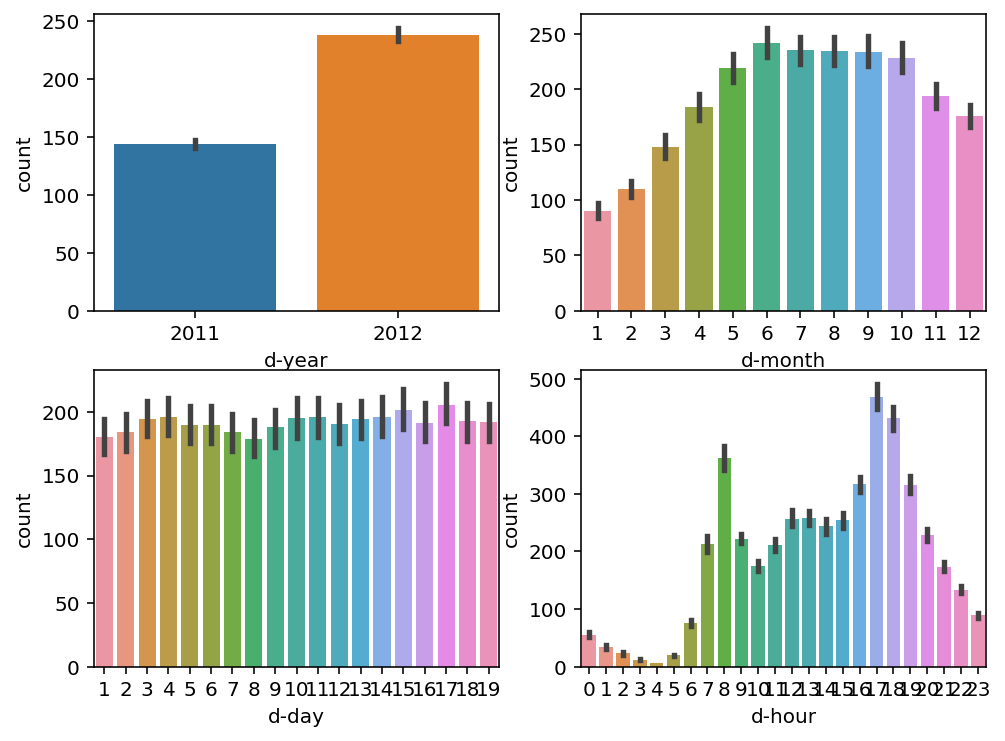

In [47]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
              figsize=(8,6))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.barplot(data=df, x="d-hour", y="count", ax=ax4)

<AxesSubplot:xlabel='d-hour', ylabel='count'>

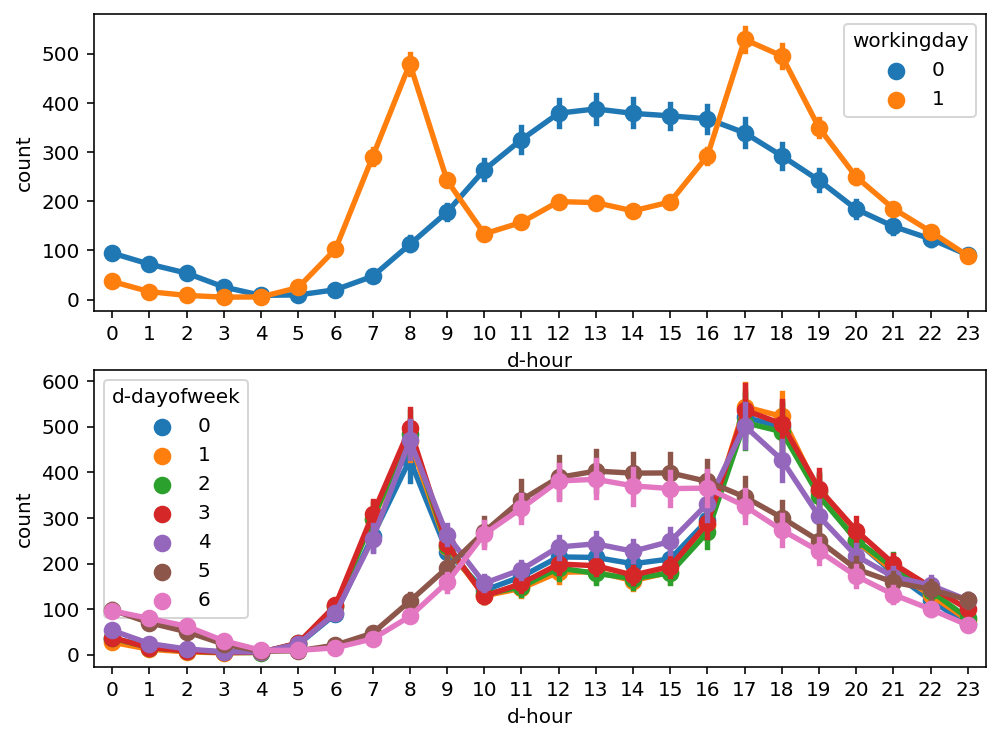

In [48]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(8, 6)

sns.pointplot(data=df, x="d-hour", y="count", hue="workingday", ax=ax1)   #workingday 일하는 날, 쉬는 날로 구분
sns.pointplot(data=df, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)  #월 화 수 목.. 으로 나눔

## 훈련에 사용할 특성 선택

In [49]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-dayofweek'],
      dtype='object')

In [95]:
features = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
            "humidity", "windspeed", "d-year", "d-hour", "d-dayofweek"]

#features = ["season", "holiday", "workingday", "temp","d-hour", "d-dayofweek"]  # 6개 특징을 써보겠다

## 랜덤 포레스트
### 데이터 셔플링 (train_test_split)

In [96]:
X = df[features].values   #해당 6개 컬럼
y = count
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [97]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.9390072151565424

- 성능이 매우 좋다

### 주요 특성 변수

In [53]:
def feature_importances_fig(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

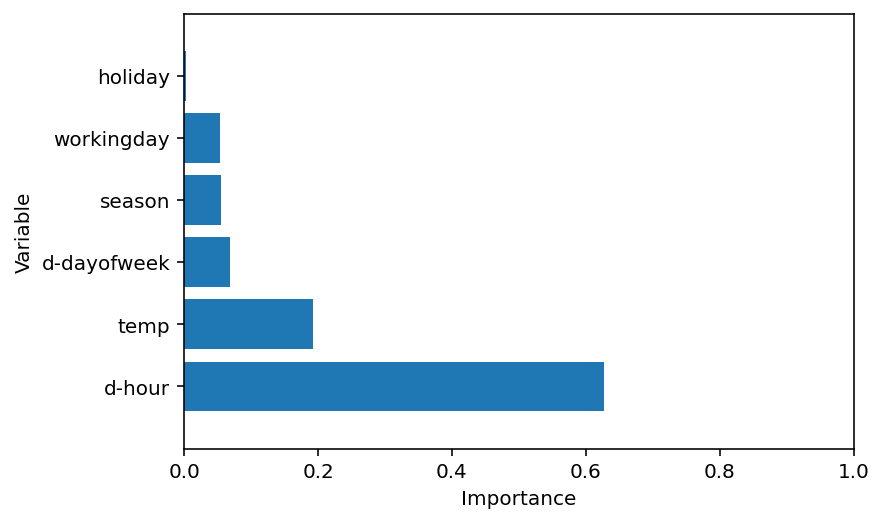

In [54]:
feature_importances_fig(features, model.feature_importances_)


#특징들의 중요도 순위

### 시각화 함수

In [98]:
# 실제값과 예측치 비교
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

In [99]:
def scatter_errors(y_test, y_pred):
    error = abs(y_test - y_pred)
    plt.scatter(y_test, error, s=2)

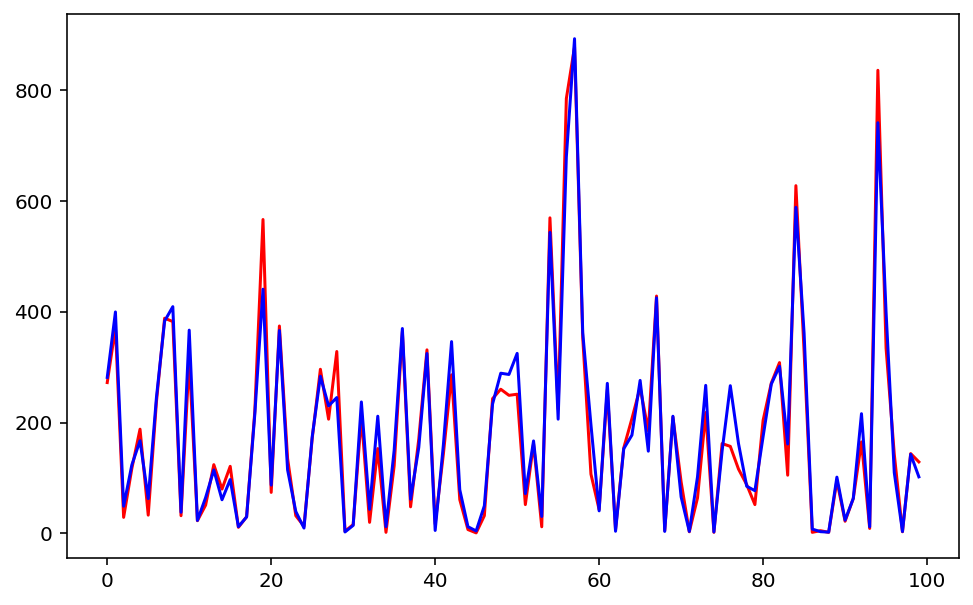

R2= 0.964
MAE= 22.386
rmse= 34.296
max= 125.63


In [100]:
y_pred = model.predict(X_test)
plot_y_pred(y_test[:100], y_pred[:100])

#꽤 비슷하다
#평균 22.386 이정도 오차가 생기다

In [101]:
np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[272. , 281.3],
       [371. , 399.3],
       [ 29. ,  49.1],
       [117. , 123.5],
       [188. , 167.2],
       [ 33. ,  62.8],
       [237. , 244.8],
       [388. , 382.9],
       [382. , 408.8],
       [ 32. ,  38.2]])

# 선형 모델

In [102]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

((7620,), (3266,))

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [103]:
def split_seq_2(sequence, n_steps_in, n_steps_out):
    x, y = [],[]
    for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

## 적절한 n_steps_in 찾기

In [104]:
lr= LinearRegression()
for n_steps in range(1,24*20,24):
  x_train, y_train = split_seq_2(train, n_steps, 1)
  x_test, y_test = split_seq_2(test, n_steps, 1)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(3))

1 0.662
25 0.866
49 0.877
73 0.883
97 0.886
121 0.89
145 0.897
169 0.902
193 0.901
217 0.902
241 0.902
265 0.901
289 0.901
313 0.901
337 0.901
361 0.901
385 0.902
409 0.902
433 0.901
457 0.901


### 최적값 선택

240 0.902


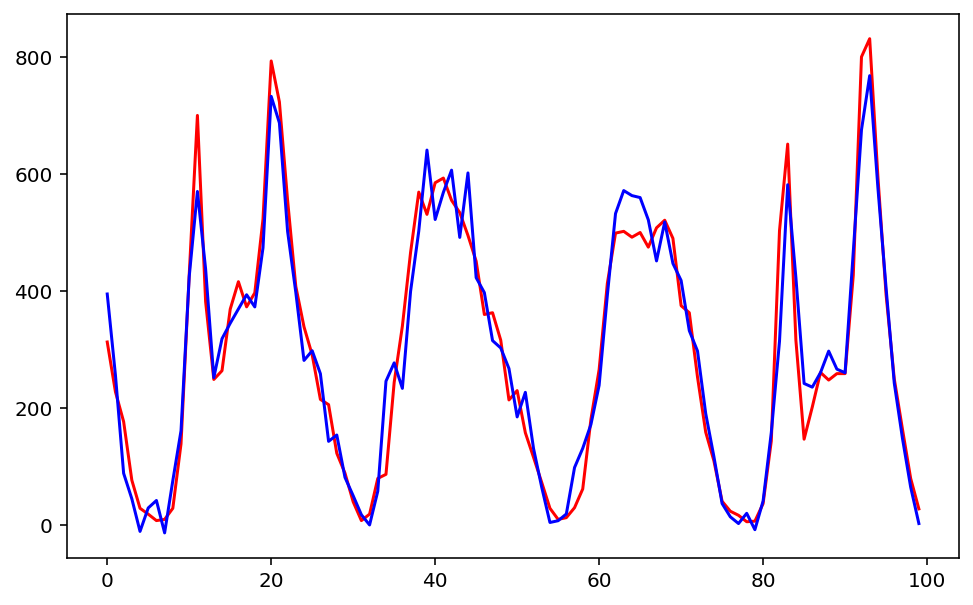

R2= 0.936
MAE= 41.124
rmse= 54.013
max= 188.89


In [105]:
n_steps = 10*24
x_train, y_train = split_seq_2(train, n_steps, 1)
x_test, y_test = split_seq_2(test, n_steps, 1)
lr.fit(x_train, y_train) 
print(n_steps, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])


#한 시간 후로 한거라, 잘 맞춘 것이다. 
#별로 의미가 없는 예측이다

- 1시간 후를 예측했으므로 정확하다

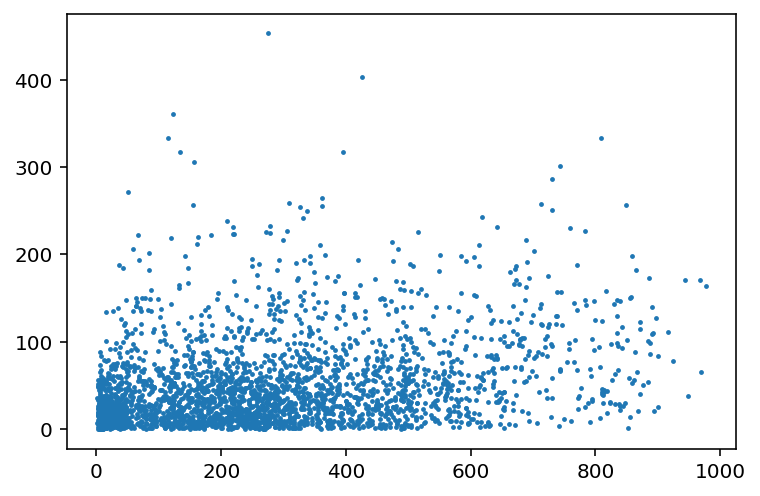

In [63]:
scatter_errors(y_test, y_pred)

#오차가 없다

## 미래 예측

In [64]:
# 좀 더 먼 미래 예측
lr = LinearRegression()
n_steps_in = 10*24
n_futures = [1,24, 24*7, 24*7*2, 24*7*3, 24*7*10]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))
    
    #168: 일주일 후 보니, 성능이 확 떨어진다

1 : 0.902
24 : 0.767
168 : 0.727
336 : 0.679
504 : 0.596
1680 : -0.386


## 최적값 선택 in, out

In [65]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

168 , 0.727


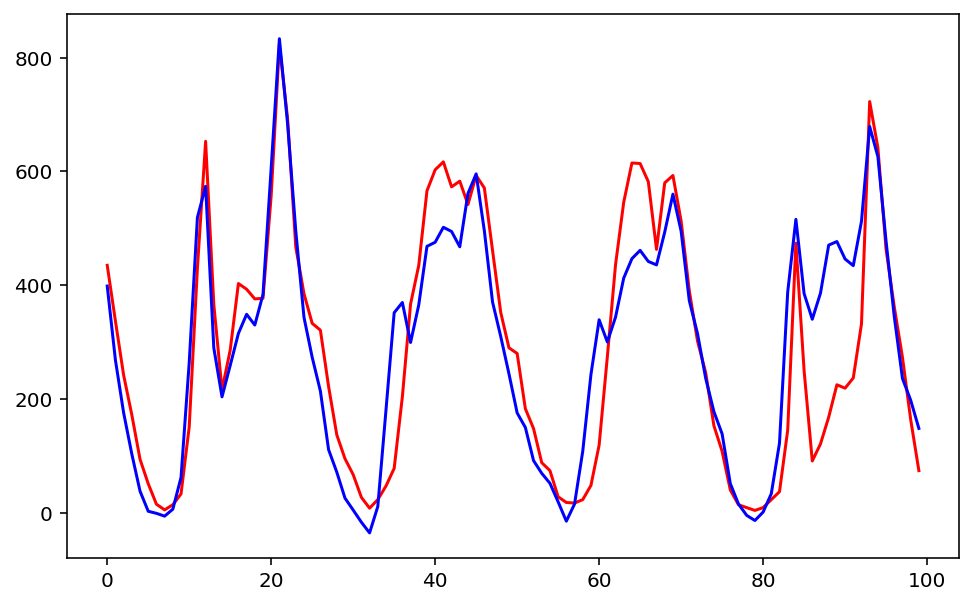

R2= 0.775
MAE= 74.519
rmse= 102.58
max= 302.522


In [66]:
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

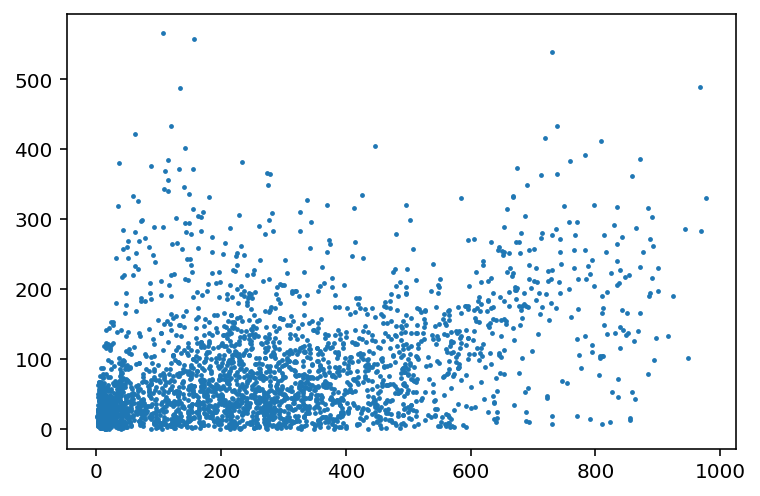

In [67]:
scatter_errors(y_test, y_pred)

# 신경망 사용
- 시간이 오래 걸리므로 colab에서 실행 권장

In [68]:
n_steps_in = 24*10
n_steps_out= 24*7  #시간, 일주일 뒤 보는 것 똑같게  앞에서 했던 것과 같이
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)

## MLP

In [109]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=n_steps_in)) 
model.add(Dense(200, activation='relu'))  #계층이 2개 있는 간단한 신경망
model.add(Dense(1)) # 회귀분석 (분류: softmax)

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               48200     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 88,601
Trainable params: 88,601
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])  #성능이 5번 이상 개선 되지 않으면 꺼지도록

Epoch 1/100
296/296 [==============================] - 1s 2ms/step - loss: 5225.6201 - val_loss: 5824.0718
Epoch 2/100
296/296 [==============================] - 0s 1ms/step - loss: 2947.9390 - val_loss: 5750.0361
Epoch 3/100
296/296 [==============================] - 0s 1ms/step - loss: 2564.0535 - val_loss: 4685.1323
Epoch 4/100
296/296 [==============================] - 0s 1ms/step - loss: 2198.3984 - val_loss: 5946.7188
Epoch 5/100
296/296 [==============================] - 0s 1ms/step - loss: 1919.6467 - val_loss: 3356.0115
Epoch 6/100
296/296 [==============================] - 0s 1ms/step - loss: 1804.6536 - val_loss: 3223.2063
Epoch 7/100
296/296 [==============================] - 0s 1ms/step - loss: 1694.9888 - val_loss: 2808.4902
Epoch 8/100
296/296 [==============================] - 0s 1ms/step - loss: 1622.2303 - val_loss: 4341.0371
Epoch 9/100
296/296 [==============================] - 0s 1ms/step - loss: 1490.0498 - val_loss: 3363.7568
Epoch 10/100
296/296 [===============

In [112]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.8827337877576361

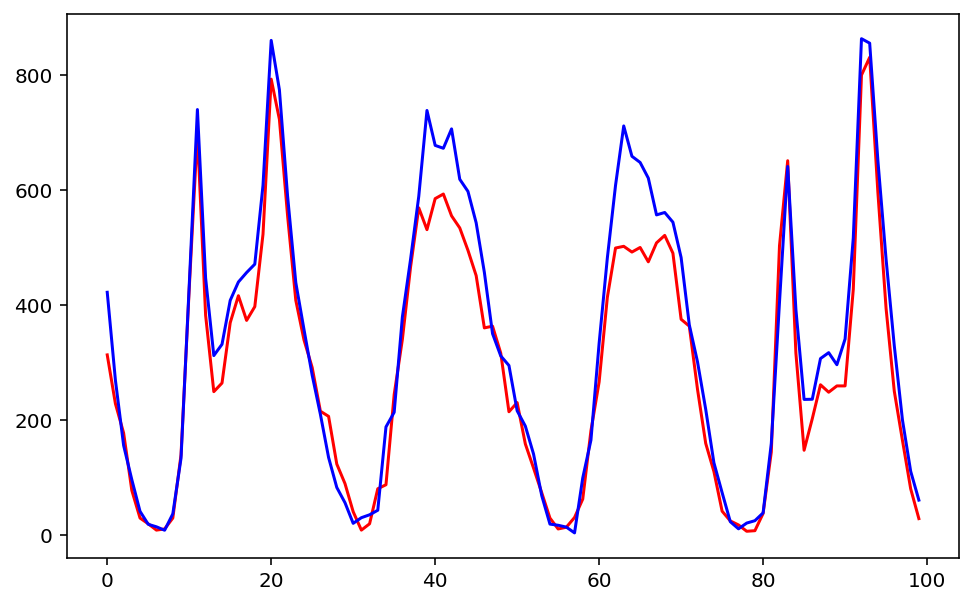

R2= 0.902
MAE= 263.031
rmse= 325.623


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [113]:
plot_y_pred(y_test[:100], y_pred[:100])

In [84]:
y_pred

array([[374.2024 ],
       [253.3971 ],
       [175.34874],
       ...,
       [158.47905],
       [112.39974],
       [ 78.66043]], dtype=float32)

In [85]:
y_pred.shape

(2859, 1)

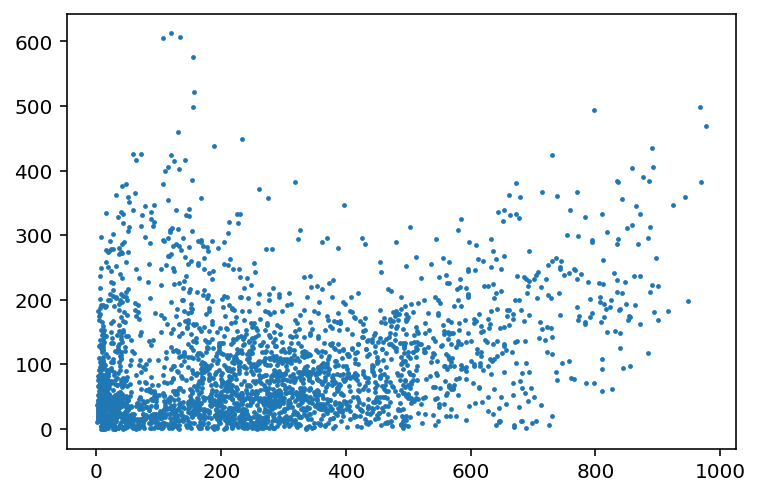

In [86]:
scatter_errors(y_test, y_pred.ravel())

## CNN

In [77]:
#회귀분석에서 CNN은 효과가 없다. 패턴 찾는데는 도움이 되지만  수업에선 skip~


model = Sequential()
model.add(Reshape((n_steps_in,1), input_shape=(n_steps_in,)))
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in,1))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 240, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 239, 64)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 119, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
flatten (Flatten)            (None, 7424)             

In [78]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
289/289 [==============================] - 3s 9ms/step - loss: 9560.6543 - val_loss: 14003.2070
Epoch 2/100
289/289 [==============================] - 2s 8ms/step - loss: 7450.3687 - val_loss: 15977.2900
Epoch 3/100
289/289 [==============================] - 2s 9ms/step - loss: 7091.3013 - val_loss: 13165.4580
Epoch 4/100
289/289 [==============================] - 3s 10ms/step - loss: 6964.0864 - val_loss: 15230.3760
Epoch 5/100
289/289 [==============================] - 4s 13ms/step - loss: 6788.3784 - val_loss: 17444.9727
Epoch 6/100
289/289 [==============================] - 4s 13ms/step - loss: 6586.9531 - val_loss: 15672.3838
Epoch 7/100
289/289 [==============================] - 4s 13ms/step - loss: 6194.9976 - val_loss: 14719.5811
Epoch 8/100
289/289 [==============================] - 5s 16ms/step - loss: 6047.4067 - val_loss: 16769.0234


In [87]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.6451426209874576

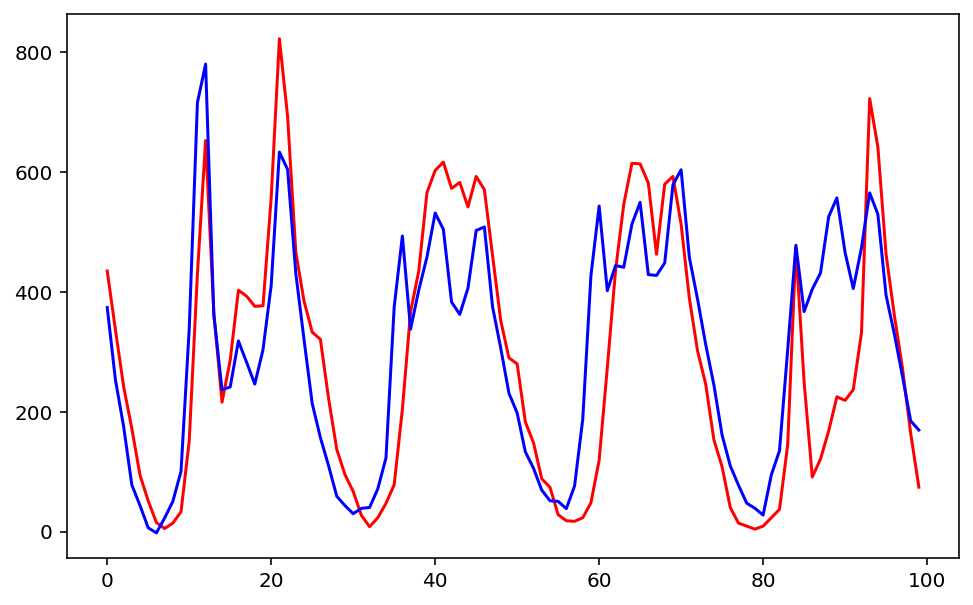

R2= 0.608
MAE= 234.443
rmse= 288.086


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [88]:
plot_y_pred(y_test[:100], y_pred[:100])

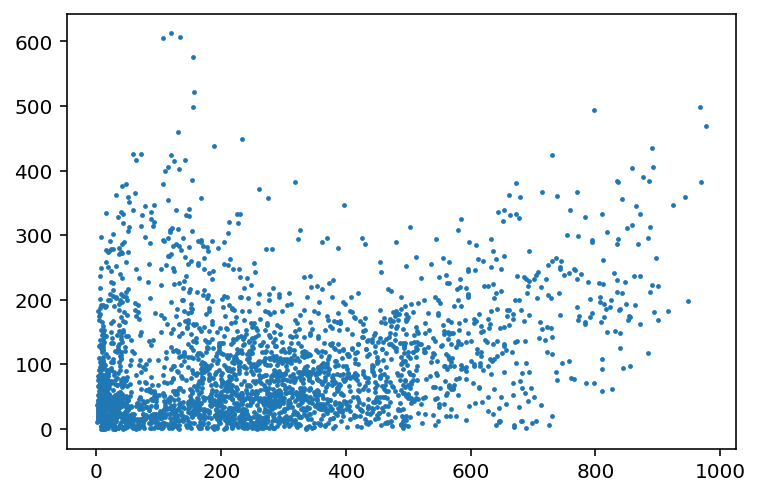

In [89]:
scatter_errors(y_test, y_pred[:,0])

## RNN

In [90]:
#시계열 분석에서는 rnn을 쓰면 도움이 되니 성능이 좋다
model = Sequential()
model.add(Reshape((n_steps_in,1), input_shape=(n_steps_in,)))
model.add(GRU(64, activation='elu', input_shape=(n_steps_in, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 240, 1)            0         
_________________________________________________________________
gru (GRU)                    (None, 240, 64)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 240, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


In [91]:
#RNN은 CNN의 계산량이 4배 정도 된다. - 시간이 오래 걸린다.
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
289/289 [==============================] - 61s 206ms/step - loss: 11996.8516 - val_loss: 16455.4414
Epoch 2/100
289/289 [==============================] - 66s 227ms/step - loss: 8535.6836 - val_loss: 14594.0039
Epoch 3/100
289/289 [==============================] - 66s 228ms/step - loss: 8278.7480 - val_loss: 17009.9023
Epoch 4/100
289/289 [==============================] - 67s 233ms/step - loss: 8092.4526 - val_loss: 16015.2852
Epoch 5/100
289/289 [==============================] - 66s 228ms/step - loss: 7936.5596 - val_loss: 16207.2256
Epoch 6/100
289/289 [==============================] - 65s 224ms/step - loss: 7913.5562 - val_loss: 15616.7363
Epoch 7/100
289/289 [==============================] - 62s 214ms/step - loss: 7887.7109 - val_loss: 15691.9736


In [92]:
y_pred = model.predict(test_x)
r2_score(test_y, y_pred)

NameError: name 'test_x' is not defined

In [ ]:
plot_y_pred(test_y[:100], y_pred[:100])

In [ ]:
scatter_errors(test_y, y_pred[:,0])

In [ ]:
y_pred = model.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

In [ ]:
scatter_errors(y_test, y_pred)

## 공부는 여기 까지

# 다중변수 예측 - 이하는 참고(여기 아래부터는 시험범위 x )

In [ ]:
features = ["count", "temp", "humidity","season", "workingday",  "d-year", "d-hour"]
continuous_features = ["count", "temp", "humidity"]
discrete_features = ["season", "workingday", "d-year", "d-hour"]
X2 = df[features]

In [ ]:
X2.nunique()

In [47]:
X = pd.get_dummies(X2, columns = discrete_features)
X[:3].T

,0,1,2
count,16.00,40.00,32.00
temp,9.84,9.02,9.02
humidity,81.00,80.00,80.00
season_1,1.00,1.00,1.00
season_2,0.00,0.00,0.00
season_3,0.00,0.00,0.00
season_4,0.00,0.00,0.00
workingday_0,1.00,1.00,1.00
workingday_1,0.00,0.00,0.00
d-year_2011,1.00,1.00,1.00


In [48]:
sc = StandardScaler()  #아날로그 값들 표준화 해주다 
X[continuous_features] = sc.fit_transform(X[continuous_features])
X[:3].T

,0,1,2
count,-0.969294,-0.836797,-0.880962
temp,-1.333661,-1.438907,-1.438907
humidity,0.993213,0.941249,0.941249
season_1,1.000000,1.000000,1.000000
season_2,0.000000,0.000000,0.000000
season_3,0.000000,0.000000,0.000000
season_4,0.000000,0.000000,0.000000
workingday_0,1.000000,1.000000,1.000000
workingday_1,0.000000,0.000000,0.000000
d-year_2011,1.000000,1.000000,1.000000


In [49]:
# 표준 스케일링 변수 (표준편차와 평균)
sc.scale_, sc.mean_

(array([181.13613357,   7.79123196,  19.24414932]),
 array([191.57413191,  20.23085982,  61.88645967]))

In [50]:
count_sigma = sc.scale_[0]
count_mean = sc.mean_[0]
count_sigma, count_mean

(181.1361335742659, 191.57413191254824)

In [52]:
len(X)

10886

In [53]:
cut = np.int((len(X)*0.7))
train = X[:cut].values
test = X[cut:].values
train.shape, test.shape


#표준화 이후 시계열 분석하다

((7620, 35), (3266, 35))

In [54]:
n_steps_in = 24*10
n_steps_out = 24 * 7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)

In [55]:
x_train.shape, y_train.shape

((7213, 240, 35), (7213, 35))

- 최종 예측치는 count만 해당됨

In [57]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [58]:
x_train.shape, y_train.shape

((7213, 240, 35), (7213,))

In [59]:
n_features = x_train.shape[-1]
n_features

35

## MLP (다중변수 멀티스텝)

In [60]:
model = Sequential()
model.add(Reshape((n_steps_in*n_features,), input_shape=(n_steps_in, n_features))) 
model.add(Dense(300, activation='relu', input_shape=(n_steps_in*n_features,))) 
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))


In [61]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train,y_train, batch_size=20, epochs=200,
                                          validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/200
289/289 [==============================] - 1s 3ms/step - loss: 0.3029 - val_loss: 0.5325
Epoch 2/200
289/289 [==============================] - 1s 3ms/step - loss: 0.2054 - val_loss: 0.5994
Epoch 3/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1741 - val_loss: 0.7163
Epoch 4/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1506 - val_loss: 0.7828
Epoch 5/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1349 - val_loss: 0.7260
Epoch 6/200
289/289 [==============================] - 1s 3ms/step - loss: 0.1182 - val_loss: 0.6781


0.604161492598539


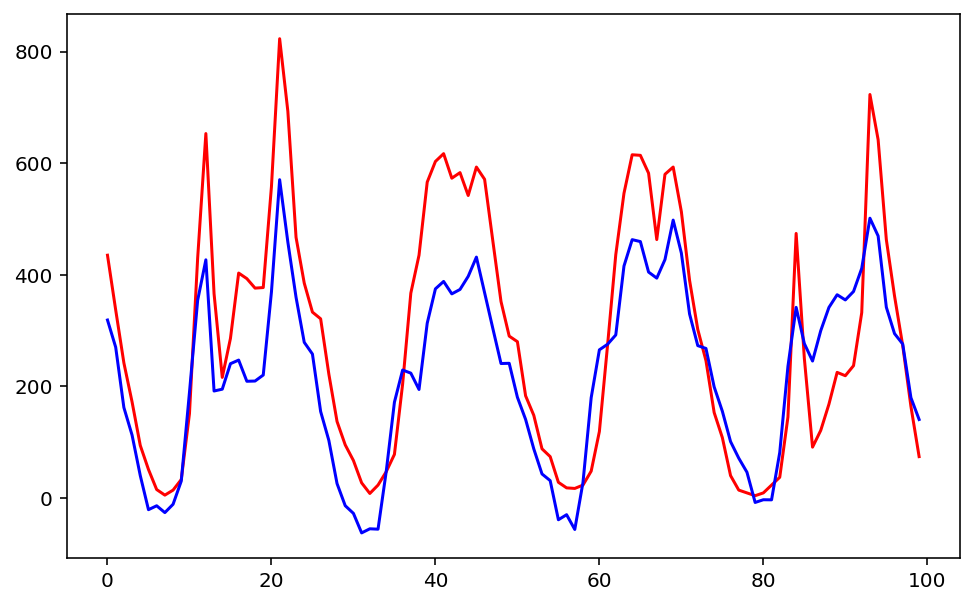

In [62]:
y_pred = model.predict(x_test)
print(r2_score(y_test, y_pred))
plot_y_pred(y_test[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)

In [63]:
count_mean

191.57413191254824

MAE= 99.556
rmse= 136.117
max= 475.339


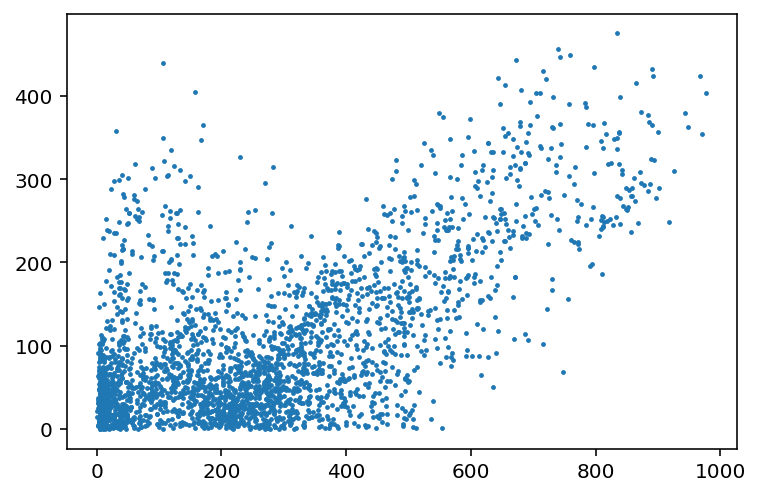

In [64]:
scatter_errors(y_test*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)

## CNN (다중변수 멀티스텝)

In [65]:
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 2))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 239, 64)           4544      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 119, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 118, 64)           8256      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 58, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 128)          

In [66]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(x_train, y_train, batch_size=20, epochs=200,
        validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/200
289/289 [==============================] - 1s 5ms/step - loss: 0.3140 - val_loss: 0.5856
Epoch 2/200
289/289 [==============================] - 1s 4ms/step - loss: 0.2356 - val_loss: 0.6554
Epoch 3/200
289/289 [==============================] - 1s 4ms/step - loss: 0.2154 - val_loss: 0.6488
Epoch 4/200
289/289 [==============================] - 1s 5ms/step - loss: 0.1979 - val_loss: 0.6401
Epoch 5/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1845 - val_loss: 0.6138
Epoch 6/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1783 - val_loss: 0.5780
Epoch 7/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1696 - val_loss: 0.6056
Epoch 8/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1639 - val_loss: 0.6387
Epoch 9/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1527 - val_loss: 0.6513
Epoch 10/200
289/289 [==============================] - 1s 4ms/step - loss: 0.1418 - val_lo

0.5464682691350005


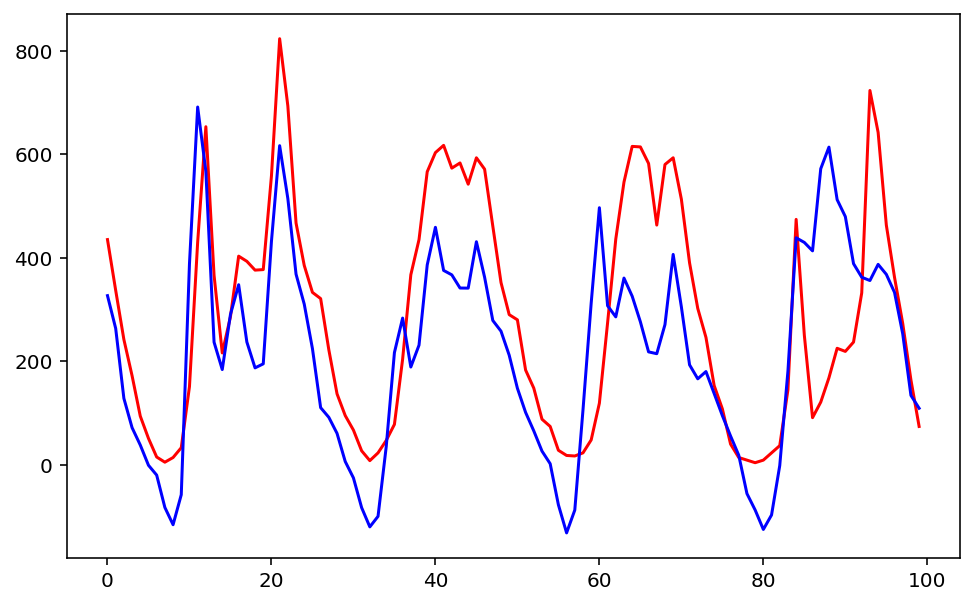

In [67]:
y_pred = model.predict(x_test)
print(r2_score(y_test, y_pred))
plot_y_pred(y_test[:100]*count_sigma+count_mean, y_pred[:100]*count_sigma+count_mean)


#성능이 그닥

MAE= 114.12
rmse= 145.699
max= 573.846


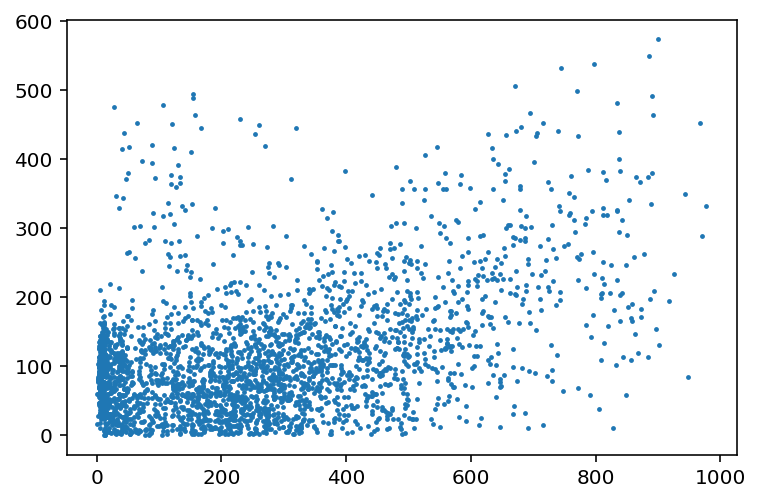

In [68]:
scatter_errors(y_test*count_sigma+count_mean, y_pred[:,0]*count_sigma+count_mean)